# CountVectorizer Models

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

## Import Data

In [2]:
posts = pd.read_csv('../data/combined_genz_mill_posts.csv')

In [3]:
posts.head()

,title,selftext,subreddit
0,What have you learned this week?,NaN,r/GenZ
1,r/GenZ Is in need of more moderators! Read below:,"In the past few months, we've been getting inc...",r/GenZ
2,Who else remembers Net Neutrality and when thi...,NaN,r/GenZ
3,This sub lately.,NaN,r/GenZ
4,You guys are absolutely pathetic,Where do I even start? It's just constant comp...,r/GenZ


### Null Values

Instead of dropping any empty rows, we can combine the title and post content to create a new 'all_text' column filled with all the text in the post

In [4]:
posts.isna().sum()

title          0
selftext     543
subreddit      0
dtype: int64

In [5]:
posts['all_text'] = posts['title'] + ': ' + posts['selftext'].fillna('')

posts.head()

,title,selftext,subreddit,all_text
0,What have you learned this week?,NaN,r/GenZ,What have you learned this week?:
1,r/GenZ Is in need of more moderators! Read below:,"In the past few months, we've been getting inc...",r/GenZ,r/GenZ Is in need of more moderators! Read bel...
2,Who else remembers Net Neutrality and when thi...,NaN,r/GenZ,Who else remembers Net Neutrality and when thi...
3,This sub lately.,NaN,r/GenZ,This sub lately.:
4,You guys are absolutely pathetic,Where do I even start? It's just constant comp...,r/GenZ,You guys are absolutely pathetic: Where do I e...


In [6]:
# New 'all_text' column should have no null values
posts.isna().sum()

title          0
selftext     543
subreddit      0
all_text       0
dtype: int64

### Changing 'subreddit' to Numeric

Currently, the subreddit the post originated in is stored in the 'subreddit' column as a string. We need a numeric value to create our models.

In [7]:
posts['subreddit'].unique()

array(['r/GenZ', 'r/Millennials'], dtype=object)

We can create a new column that will be the target in our models based on whether the post is in r/GenZ

In [8]:
posts['is_gen_z'] = posts['subreddit'].map({'r/GenZ': 1, 'r/Millennials': 0})

In [9]:
posts['is_gen_z'].unique()

array([1, 0])

## Train/Test Split

We will be training our model on the combined 'all_text' column (X), with our target (y) being the 'is_gen_z' column. There is no need to stratify because the number of posts from each subreddit are similar. We have almost 2000 posts, so a standard test size of .2 should be sufficient. We can use a random state of 42 to keep our findings consistent.

In [10]:
X = posts['all_text']
y = posts['is_gen_z']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

### Baseline Accuracy
The proportions of each subreddit in the y_train will give us the baseline accuracy. This baseline accuracy will be the same accross all models we make going forward. 

In [11]:
y_train.value_counts(normalize=True)

is_gen_z
1    0.501948
0    0.498052
Name: proportion, dtype: float64

If the proprtions in the y_test set are simlar to y_train, it will confirm we do not need to stratify our data.

In [12]:
y_test.value_counts(normalize=True)

is_gen_z
0    0.502591
1    0.497409
Name: proportion, dtype: float64

## Logistic Regression

In [13]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

The parameters we are searching over will be a limit for the maximum features or words included, stop words , a minimum and maximum frequency in the data, and an accent stripper to properly format the data. The model will also try combinations of words that appear next to each other.

In [21]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, None],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [2, 4, 50],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__strip_accents': ['ascii', 'unicode'],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

In [22]:
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs=-1)

In [ ]:
gs.fit(X_train, y_train)

In [24]:
print(gs.best_score_)
gs.best_params_

0.7363636363636363


{'cvec__max_df': 1.0,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'unicode',
 'lr__penalty': 'l2'}

In [25]:
print(f"Training score: {gs.score(X_train, y_train)}")
print(f"Testing score: {gs.score(X_test, y_test)}")

Training score: 0.9759740259740259
Testing score: 0.7979274611398963


**Interpretation:** This combination of using Count Vectorizer to set up a logistic regression significantly outperformed the baseline accuracy. This model achieved a test score of .7979 compared to the score of .5019 from the baseline accuracy. The top performing parameters include removing english stop words, formatting the data using unicode, and a max feature count of 3000.

### Visualizations

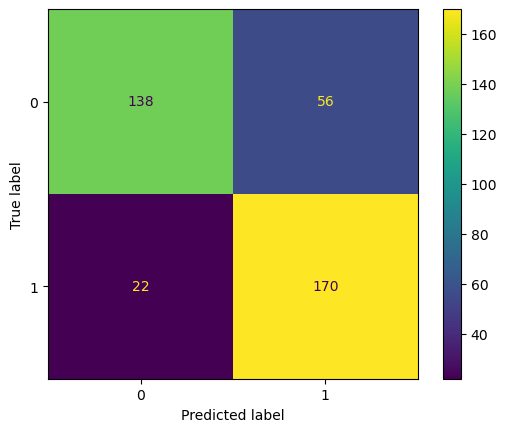

In [26]:
# Create Confusion Matrix
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds),
                             display_labels=gs.classes_)
disp.plot();

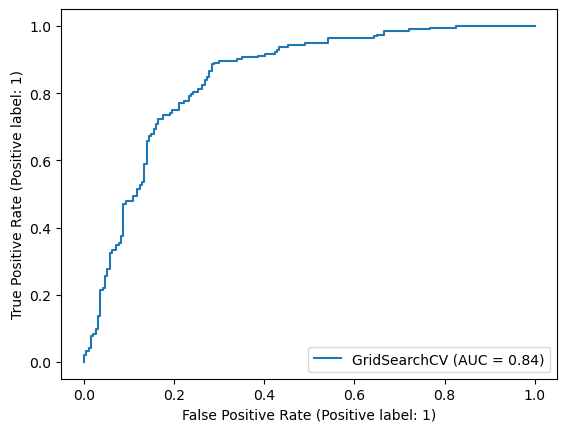

In [27]:
# Plot Roc Curve
RocCurveDisplay.from_estimator(gs, X_test, y_test);

**Interpretations:** False positive's are the biggest issue in this model, with 56, compared to only 22 false negatives. When predicting that a post was made in r/GenZ, this model was correct 75.22% of the time, compared to 86.25% of the time when predicting that a post was made in r/Millennials.

## Multinomial Naive Bayes

We will now repeat the analysis above on a model that uses Naive Bayes instead of a Logistic Regression.

In [28]:
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

We will be searching over similar parameters, making sure to include ones that were successful in previous models.

In [29]:
pipe_params_nb = {
    'cvec__max_features': [2000, 3000, 4000, None],
    'cvec__min_df': [2, 4, .1],
    'cvec__max_df': [1.0, 0.9, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__strip_accents': ['ascii', 'unicode']
}

In [30]:
gs_nb = GridSearchCV(pipe_nb,
                 param_grid=pipe_params_nb,
                 n_jobs=-1)

In [31]:
gs_nb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [1.0, 0.9, 0.8],
                         'cvec__max_features': [2000, 3000, 4000, None],
                         'cvec__min_df': [2, 4, 0.1],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__strip_accents': ['ascii', 'unicode']})

In [32]:
print(gs_nb.best_score_)
gs_nb.best_params_

0.7084415584415584


{'cvec__max_df': 1.0,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'cvec__strip_accents': 'ascii'}

In [33]:
print(f"Training score: {gs_nb.score(X_train, y_train)}")
print(f"Testing score: {gs_nb.score(X_test, y_test)}")

Training score: 0.8415584415584415
Testing score: 0.7253886010362695


**Interpretation:** This model is not as overfit as the previous model, but the test score of 0.7254 is slightly lower. There is still a gap of .12 between our train and test scores, so the issue of overfitting wasn't completely solved. Interestingly, this model tested better with an n-gram range of (1, 3), whereas increasing the ngram range did not imporve our logistic regression model.

### Visualizations
We will also make a confusion matrix and Roc curve to visualize this model and compare to our previous iteration.

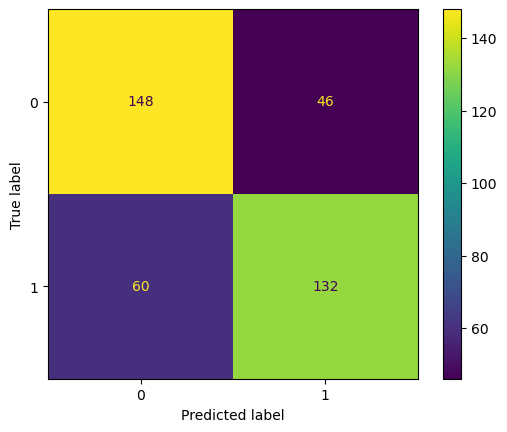

In [34]:
# Create Confusion Matrix
preds_nb = gs_nb.predict(X_test)
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(y_test, preds_nb).ravel()

# Plot Confusion Matrix
disp_nb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds_nb),
                             display_labels=gs_nb.classes_)
disp_nb.plot();

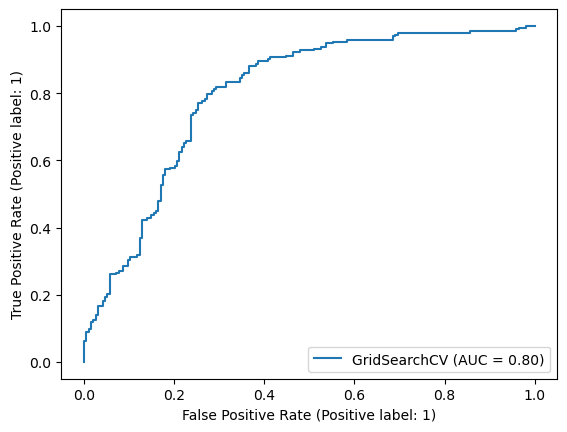

In [35]:
# Plot Roc Curve
RocCurveDisplay.from_estimator(gs_nb, X_test, y_test);

**Interpretations:** Even though the Naive Bayes model was not as strong as our logistic regression model, it is more even in it's type of errors. The false positives and false negatives are more even in this model as opposed to the logistic regression, which tended to have more false positives